# 载入数据集

In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd

In [4]:
df = pd.read_csv('../input/dog-breed-identification//labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

print(class_to_num)

{'basset': 0, 'dingo': 1, 'kelpie': 2, 'standard_poodle': 3, 'appenzeller': 4, 'weimaraner': 5, 'border_collie': 6, 'gordon_setter': 7, 'bloodhound': 8, 'pekinese': 9, 'dandie_dinmont': 10, 'sussex_spaniel': 11, 'west_highland_white_terrier': 12, 'shih-tzu': 13, 'malinois': 14, 'walker_hound': 15, 'lhasa': 16, 'irish_terrier': 17, 'borzoi': 18, 'labrador_retriever': 19, 'black-and-tan_coonhound': 20, 'japanese_spaniel': 21, 'malamute': 22, 'keeshond': 23, 'norwegian_elkhound': 24, 'siberian_husky': 25, 'curly-coated_retriever': 26, 'norwich_terrier': 27, 'bull_mastiff': 28, 'mexican_hairless': 29, 'brabancon_griffon': 30, 'chesapeake_bay_retriever': 31, 'english_setter': 32, 'lakeland_terrier': 33, 'basenji': 34, 'bluetick': 35, 'scotch_terrier': 36, 'bernese_mountain_dog': 37, 'greater_swiss_mountain_dog': 38, 'brittany_spaniel': 39, 'whippet': 40, 'toy_poodle': 41, 'norfolk_terrier': 42, 'redbone': 43, 'great_pyrenees': 44, 'eskimo_dog': 45, 'shetland_sheepdog': 46, 'silky_terrier': 

In [7]:
width = 299
X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    X[i] = cv2.resize(cv2.imread('train/%s.jpg' % df['id'][i]), (width, width))
    y[i][class_to_num[df['breed'][i]]] = 1

  0%|          | 0/10222 [00:00<?, ?it/s]


error: OpenCV(4.0.0) /io/opencv/modules/imgproc/src/resize.cpp:3784: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


# 数据集可视化

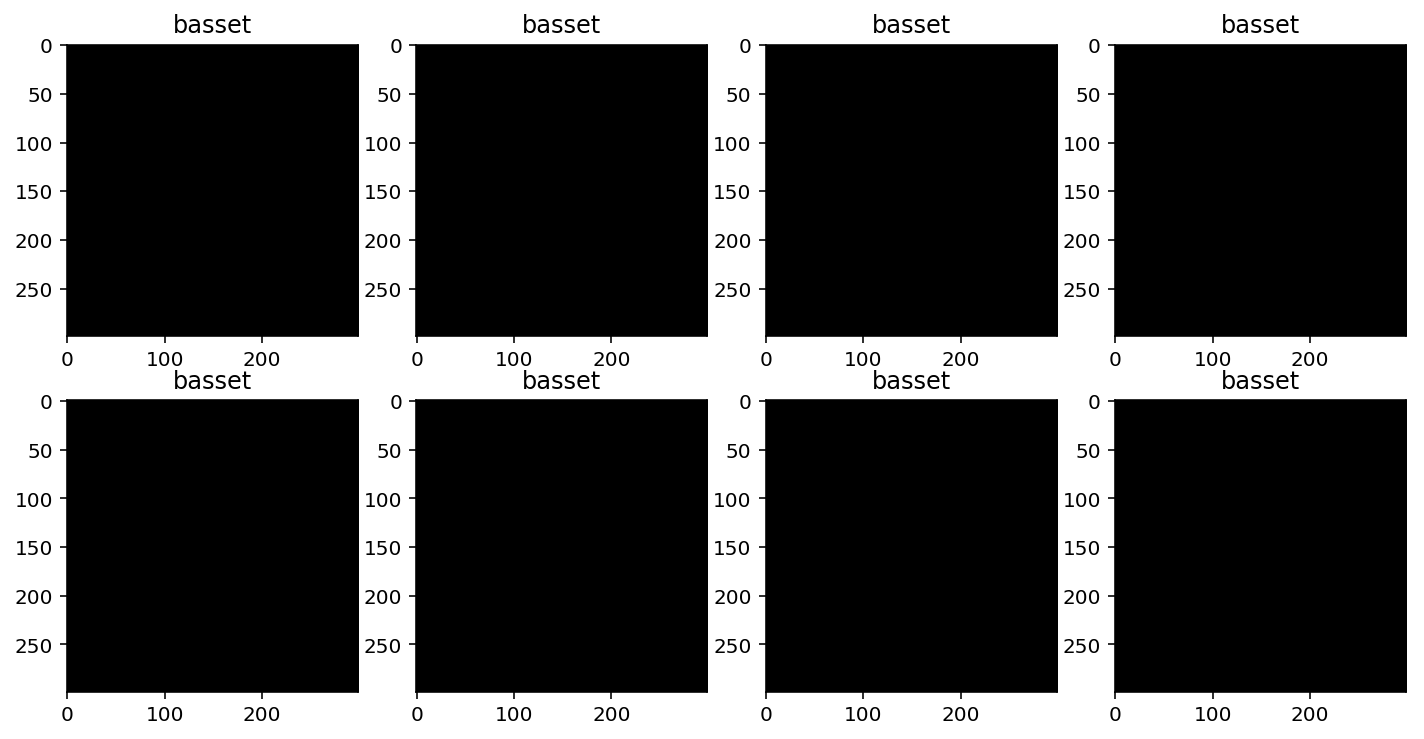

In [8]:
import random
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 6))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(num_to_class[y[random_index].argmax()])

# 导出特征

In [ ]:
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

In [ ]:
def get_features(MODEL, data=X):
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

In [ ]:
inception_features = get_features(InceptionV3, X)
xception_features = get_features(Xception, X)
features = np.concatenate([inception_features, xception_features], axis=-1)

# 训练模型

In [ ]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax')(x)
model = Model(inputs, x)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(features, y, batch_size=128, epochs=10, validation_split=0.1)

# 可视化模型

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# 可视化训练过程

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

# 载入测试集

In [ ]:
df2 = pd.read_csv('sample_submission.csv')

In [ ]:
n_test = len(df2)
X_test = np.zeros((n_test, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n_test)):
    X_test[i] = cv2.resize(cv2.imread('test/%s.jpg' % df2['id'][i]), (width, width))

# 导出测试集特征

In [ ]:
inception_features = get_features(InceptionV3, X_test)
xception_features = get_features(Xception, X_test)
features_test = np.concatenate([inception_features, xception_features], axis=-1)

# 预测测试集并输出结果

In [ ]:
y_pred = model.predict(features_test, batch_size=128)

In [ ]:
for b in breed:
    df2[b] = y_pred[:,class_to_num[b]]

In [ ]:
df2.to_csv('pred.csv', index=None)